<a href="https://colab.research.google.com/github/punar-sikka/GoldStandardTextSimplification/blob/master/GoldStandardExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import os
os.chdir("gdrive/My Drive/GoldStandardData/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!pip install textstat
import nltk
nltk.download('punkt')
import re
import textstat as ts
from nltk.tokenize import sent_tokenize
import pandas as pd
import numpy as np

     |████████████████████████████████| 102kB 1.7MB/s 
     |████████████████████████████████| 3.0MB 8.3MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# load the raw datset & remove header
lines = [line.rstrip('\n') for line in open('t1verses.csv')]
lines=lines[1:]

In [ ]:
lines[1000]

'14687,3,"We changed your allowable reserve under Part 2 of Form T1139, Reconciliation of <<VARI>> Business Income for Tax Purposes, from <<VARI>><<VARI>> to <<VARI>><<VARI>>. The maximum reserve you can claim is <<VARI>><<VARI>>. We changed your net self-employment income to reflect this change.",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,'

In [ ]:
#pre-process data
for i in range(len(lines)):
    #remove extra commas from end of lines
    while lines[i][len(lines[i])-1] == ',':
        lines[i] = lines[i][:-1]
    
    #remove variable names
    lines[i] = re.sub(r" <<(.*?)>>", "", lines[i])
    lines[i] = re.sub(r"<<(.*?)>>", "", lines[i])
    while '\t' in lines[i]:
        lines[i] = lines[i].replace('\t', '')
    while '  ' in lines[i]:
        lines[i] = lines[i].replace('  ', ' ')

In [ ]:
lines[1000]

'14687,3,"We changed your allowable reserve under Part 2 of Form T1139, Reconciliation of Business Income for Tax Purposes, from to. The maximum reserve you can claim is. We changed your net self-employment income to reflect this change."'

In [ ]:
#organize data into dictionary
versesDict = {}
for l in lines:
    tokens = l.split(',')
    verseID = (int)(tokens[0])
    versionID = (int)(tokens[1])
    
    #ignore empty texts
    if len(tokens) <=2 or tokens[2] == '':
        continue
    
    #combine the rest of the tokens into text
    verseText = tokens[2]
    if len(tokens) > 3:
        for i in range(3, len(tokens)):
            verseText = verseText + ',' + tokens[i]
    
    #remove leading and trailing double quotes
    if verseText[0] == '"':
        verseText = verseText[1:]
    if verseText[len(verseText)-1] == '"':
        verseText = verseText[:-1]
    
    if verseID not in versesDict:
        #insert key
        versesDict[verseID] = {}
    versesDict[verseID][versionID] = verseText

In [ ]:
versesDict[14687][3]

'We changed your allowable reserve under Part 2 of Form T1139, Reconciliation of Business Income for Tax Purposes, from to. The maximum reserve you can claim is. We changed your net self-employment income to reflect this change.'

In [ ]:
#Get number of instances for each level of simplification
numSimplifications = {}
for v in versesDict:
    if len(versesDict[v]) not in numSimplifications:
        numSimplifications[len(versesDict[v])] = 1
    else:
        numSimplifications[len(versesDict[v])] +=1

for i in sorted (numSimplifications) : 
    print ((i, numSimplifications[i]), end =" ")

(1, 12317) (2, 6779) (3, 2234) (4, 711) (5, 292) (6, 118) (7, 77) (8, 26) (9, 15) (10, 8) (11, 6) (12, 1) (13, 1) (15, 1) 

In [ ]:
sent_pairs = []
for v in versesDict:
    #ignore sentences with no simplifications (only contains 1 version of the sentence)
    if len(versesDict[v]) <= 1:
        continue
    tmpKeysList = list(versesDict[v].keys())
    tmpKeysList.sort()

    for k in tmpKeysList:
        for k1 in tmpKeysList:
            if k1 > k:
                tmpPair = [versesDict[v][k], versesDict[v][k1]]
                alreadyExists = False
                for sp in sent_pairs:
                    if (sp[0] == tmpPair[0] and sp[1] == tmpPair[1]):
                        alreadyExists = True
                        break
                if not alreadyExists:
                    sent_pairs.append(tmpPair)

In [ ]:
len(sent_pairs)

18126

In [ ]:
orderedPairs = []
for p in sent_pairs:
    #if the simplified version is longer and has higher Flesh Kincaid Grade
    if (ts.char_count(p[1]) > ts.char_count(p[0]) and 
        ts.flesch_kincaid_grade(p[1]) > ts.flesch_kincaid_grade(p[0])):
        #switch the sentence pair
        orderedPairs.append([p[1], p[0]])
    else:
        orderedPairs.append([p[0], p[1]])
print(len(orderedPairs))

18126


In [ ]:
# Set to False to select all data
# Set True to select verses that contain single sentence ONLY
SELECT_SINGLE_SENTS = False

if SELECT_SINGLE_SENTS:
    singlePairs = []
    for p in orderedPairs:
        if len(sent_tokenize(p[0])) == 1 and len(sent_tokenize(p[1])) == 1:
            singlePairs.append(p)
    orderedPairs = singlePairs
print(len(orderedPairs))

18126


In [ ]:
OUTPUT_SENT_PAIRS = False

if OUTPUT_SENT_PAIRS:
    fileNorm = open('t1VersesNorm.txt', "w")
    fileSimp = open('t1VersesSimp.txt', "w")

    for p in orderedPairs:
        fileNorm.write(p[0] + '\n')
        fileSimp.write(p[1] + '\n')
    fileNorm.close()
    fileSimp.close()

Filtering and analysis

In [ ]:
#output metrics to file

fileMetrics = open('t1Metrics.tsv', "w")
metricLines = []
header = 'ComplexSent\tSimpleSent\t'
header = header + 'cChars\tcFlesch\tcColeman\tcAri\tcLinsear\tcFog\tcAggr\t'
header = header + 'sChars\tsFlesch\tsColeman\tsAri\tsLinsear\tsFog\tsAggr\t'
header = header + 'CharsDiff\tFleschDiff\tColemanDiff\tAriDiff\tLinsearDiff\tFogDiff\tAggrDiff\n'
metricLines.append(header)
for p in orderedPairs:
    tmpLine = p[0] + "\t" + p[1] + "\t"
    #Metrics for Complex Text
    tmpLine = (tmpLine + str(ts.char_count(p[0])) + "\t" + 
                   str(ts.flesch_kincaid_grade(p[0])) + "\t" + 
                   str(ts.coleman_liau_index(p[0])) + '\t' + 
                   str(ts.automated_readability_index(p[0])) + '\t' + 
                   str(ts.linsear_write_formula(p[0])) + '\t' + 
                   str(ts.gunning_fog(p[0])) + '\t' + 
                   str(ts.text_standard(p[0], float_output=True)) + '\t')
    #Metrics for Simple Text
    tmpLine = (tmpLine + str(ts.char_count(p[1])) + "\t" + 
                   str(ts.flesch_kincaid_grade(p[1])) + "\t" + 
                   str(ts.coleman_liau_index(p[1])) + '\t' + 
                   str(ts.automated_readability_index(p[1])) + '\t' + 
                   str(ts.linsear_write_formula(p[1])) + '\t' + 
                   str(ts.gunning_fog(p[1])) + '\t' + 
                   str(ts.text_standard(p[1], float_output=True)) + '\t')
    #Metric differences
    tmpLine = (tmpLine + str(ts.char_count(p[1]) - ts.char_count(p[0])) + "\t" + 
                   str(ts.flesch_kincaid_grade(p[1]) - ts.flesch_kincaid_grade(p[0])) + "\t" + 
                   str(ts.coleman_liau_index(p[1]) - ts.coleman_liau_index(p[0])) + '\t' + 
                   str(ts.automated_readability_index(p[1]) - ts.automated_readability_index(p[0])) + '\t' + 
                   str(ts.linsear_write_formula(p[1]) - ts.linsear_write_formula(p[0])) + '\t' + 
                   str(ts.gunning_fog(p[1]) - ts.gunning_fog(p[0])) + '\t' + 
                   str(ts.text_standard(p[1], float_output=True) - ts.text_standard(p[0], float_output=True)))

    tmpLine = tmpLine.replace("\n", "")
    tmpLine = tmpLine + "\n"
    metricLines.append(tmpLine)
fileMetrics.writelines(metricLines)
fileMetrics.close()

In [ ]:
#read metrics from file
df = pd.read_csv('t1Metrics.tsv', sep='\t')

In [ ]:
df.head()

,ComplexSent,SimpleSent,cChars,cFlesch,cColeman,cAri,cLinsear,cFog,cAggr,sChars,sFlesch,sColeman,sAri,sLinsear,sFog,sAggr,CharsDiff,FleschDiff,ColemanDiff,AriDiff,LinsearDiff,FogDiff,AggrDiff
0,We have disallowed your claim of for as it is ...,We disallowed your claim of for because it is ...,50,4.4,5.50,4.2,7.00,11.47,7.0,50,7.2,9.66,7.1,6.0000,12.00,8.0,0,2.8,4.16,2.9,-1.0000,0.53,1.0
1,We disallowed your claim of for because it is ...,We disallowed your claim of for because it is ...,50,7.2,9.66,7.1,6.00,12.00,8.0,50,7.2,9.66,7.1,6.0000,12.00,8.0,0,0.0,0.00,0.0,0.0000,0.00,0.0
2,We have allowed you a deduction of from your i...,We deducted from your income because you have ...,94,8.7,6.45,9.3,13.50,12.68,7.0,76,6.8,6.61,7.4,11.0000,11.64,7.0,-18,-1.9,0.16,-1.9,-2.5000,-1.04,0.0
3,Account Number,Account Number,13,8.8,7.10,10.2,0.00,0.80,0.0,13,8.8,7.10,10.2,0.0000,0.80,0.0,0,0.0,0.00,0.0,0.0000,0.00,0.0
4,We have not allowed the claim you made to be t...,We disallowed your claim to be tax exempt beca...,469,6.9,8.80,7.3,6.75,9.41,7.0,472,6.9,8.51,7.2,6.8125,9.40,7.0,3,0.0,-0.29,-0.1,0.0625,-0.01,0.0


In [ ]:
df['cNumSentences'] = df.apply(lambda row: len(sent_tokenize(row.ComplexSent)), axis = 1)
df['sNumSentences'] = df.apply(lambda row: len(sent_tokenize(row.SimpleSent)), axis = 1)

In [ ]:
df.describe()

,cChars,cFlesch,cColeman,cAri,cLinsear,cFog,cAggr,sChars,sFlesch,sColeman,sAri,sLinsear,sFog,sAggr,CharsDiff,FleschDiff,ColemanDiff,AriDiff,LinsearDiff,FogDiff,AggrDiff,cNumSentences,sNumSentences
count,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000,18126.000000
mean,403.381717,11.811657,11.306097,14.065949,13.588646,13.899963,11.952720,377.600188,10.316584,10.569726,12.304474,11.775787,12.323808,10.834988,-25.781529,-1.495073,-0.736371,-1.761475,-1.812859,-1.576155,-1.117731,3.676045,3.597374
std,599.175089,7.332392,4.317547,9.280936,9.992660,7.348930,6.212497,587.133316,5.738099,4.376087,7.067923,7.989109,5.779469,5.212544,171.888001,5.081977,2.702518,6.417017,6.336120,5.172763,4.863504,4.760271,4.530246
min,0.000000,-15.700000,-33.810000,-11.600000,-1.000000,0.000000,0.000000,0.000000,-15.700000,-33.810000,-11.600000,-1.000000,0.000000,0.000000,-3647.000000,-88.600000,-46.860000,-114.700000,-59.600000,-91.670000,-90.000000,0.000000,0.000000
25%,119.000000,8.500000,9.510000,9.800000,8.333333,10.530000,9.000000,105.000000,7.600000,8.880000,8.900000,7.333333,9.482500,8.000000,-25.000000,-1.800000,-1.100000,-1.900000,-2.000000,-1.970000,-2.000000,1.000000,1.000000
50%,187.000000,10.400000,11.140000,12.400000,11.833333,12.680000,11.000000,169.000000,9.500000,10.680000,11.400000,10.750000,11.510000,10.000000,-7.000000,-0.400000,0.000000,-0.400000,-0.250000,-0.170000,0.000000,2.000000,2.000000
75%,345.000000,13.100000,12.950000,15.700000,15.500000,15.490000,14.000000,312.000000,12.200000,12.557500,14.400000,14.000000,14.170000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000
max,5260.000000,110.100000,47.920000,140.600000,77.000000,114.710000,110.000000,4916.000000,109.800000,56.980000,138.000000,75.000000,110.400000,110.000000,2184.000000,92.400000,13.780000,117.200000,52.000000,93.260000,93.000000,62.000000,62.000000


In [ ]:
#Ignore all instances with negative readability indices
df1 = df[(df.cFlesch>0) & (df.cColeman>0) & (df.cAri>0) & (df.cLinsear>0) & (df.cFog>0) & (df.cAggr>0) & (df.sFlesch>0) & (df.sColeman>0) & (df.sAri>0) & (df.sLinsear>0) & (df.sFog>0) & (df.sAggr>0)]
df1.describe()

,cChars,cFlesch,cColeman,cAri,cLinsear,cFog,cAggr,sChars,sFlesch,sColeman,sAri,sLinsear,sFog,sAggr,CharsDiff,FleschDiff,ColemanDiff,AriDiff,LinsearDiff,FogDiff,AggrDiff,cNumSentences,sNumSentences
count,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000
mean,411.985405,11.824451,11.496284,14.092216,13.648302,13.943413,12.220009,388.454327,10.445341,10.920836,12.448203,11.910609,12.462354,11.100561,-23.531078,-1.379109,-0.575448,-1.644013,-1.737693,-1.481059,-1.119448,3.754350,3.689045
std,603.053063,7.066683,3.319915,8.956092,9.799271,7.077301,5.987300,594.632690,5.366958,3.134180,6.699858,7.748094,5.466988,4.945680,155.738622,4.808764,1.862111,6.173673,6.251121,4.982248,4.421057,4.797458,4.586862
min,8.000000,0.100000,0.320000,0.300000,0.500000,0.800000,1.000000,8.000000,0.100000,0.320000,0.300000,0.500000,0.800000,1.000000,-2781.000000,-88.600000,-33.660000,-113.900000,-59.600000,-90.450000,-90.000000,1.000000,1.000000
25%,122.000000,8.500000,9.570000,9.900000,8.500000,10.640000,9.000000,109.000000,7.600000,9.050000,9.000000,7.500000,9.710000,8.000000,-25.000000,-1.700000,-1.050000,-1.800000,-2.000000,-1.920000,-2.000000,1.000000,1.000000
50%,191.000000,10.400000,11.190000,12.400000,12.000000,12.680000,11.000000,173.000000,9.500000,10.730000,11.400000,10.833333,11.510000,10.000000,-7.000000,-0.400000,0.000000,-0.400000,-0.250000,-0.170000,0.000000,2.000000,2.000000
75%,354.000000,13.000000,12.950000,15.600000,15.250000,15.330000,14.000000,322.000000,12.100000,12.580000,14.400000,14.000000,14.120000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000
max,5260.000000,109.800000,47.920000,138.000000,77.000000,110.400000,110.000000,4916.000000,109.800000,46.780000,138.000000,75.000000,110.400000,110.000000,2184.000000,92.400000,12.900000,117.200000,52.000000,93.260000,93.000000,62.000000,62.000000


In [ ]:
MIN_CHAR_LENGTH = 25
# ignore instances where simple or complex sentences are shorter than MIN_CHAR_LENGTH characters
df2 = df1[(df1.cChars>MIN_CHAR_LENGTH) & (df1.sChars>MIN_CHAR_LENGTH)]
df2.describe()

,cChars,cFlesch,cColeman,cAri,cLinsear,cFog,cAggr,sChars,sFlesch,sColeman,sAri,sLinsear,sFog,sAggr,CharsDiff,FleschDiff,ColemanDiff,AriDiff,LinsearDiff,FogDiff,AggrDiff,cNumSentences,sNumSentences
count,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000,17199.000000
mean,416.722833,11.825135,11.505128,14.114507,13.803739,13.922558,12.236002,394.297343,10.456538,10.950657,12.488104,12.074316,12.447906,11.126228,-22.425490,-1.368597,-0.554471,-1.626403,-1.729423,-1.474652,-1.109774,3.790453,3.731554
std,605.200159,7.043733,3.205051,8.958580,9.768217,6.971333,5.948714,597.507058,5.296491,3.017453,6.653239,7.697445,5.298158,4.873257,151.073287,4.796854,1.775855,6.172780,6.256475,4.965937,4.408868,4.821110,4.610580
min,26.000000,0.100000,0.900000,0.300000,1.000000,1.200000,1.000000,26.000000,0.100000,0.900000,0.300000,0.500000,1.200000,1.000000,-2781.000000,-88.600000,-23.750000,-113.900000,-59.600000,-90.450000,-90.000000,1.000000,1.000000
25%,125.000000,8.500000,9.580000,9.900000,8.500000,10.640000,9.000000,112.000000,7.600000,9.110000,9.000000,7.666667,9.710000,8.000000,-25.000000,-1.700000,-1.050000,-1.800000,-2.000000,-1.930000,-2.000000,1.000000,1.000000
50%,193.000000,10.400000,11.200000,12.400000,12.000000,12.680000,11.000000,175.000000,9.600000,10.740000,11.500000,11.000000,11.510000,10.000000,-7.000000,-0.400000,0.000000,-0.400000,-0.333333,-0.190000,0.000000,2.000000,2.000000
75%,360.000000,13.000000,12.940000,15.600000,15.333333,15.310000,14.000000,327.000000,12.100000,12.580000,14.400000,14.000000,14.110000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000
max,5260.000000,109.800000,47.920000,138.000000,77.000000,110.400000,110.000000,4916.000000,109.800000,46.780000,138.000000,75.000000,110.400000,110.000000,2184.000000,92.400000,12.900000,117.200000,52.000000,93.260000,93.000000,62.000000,62.000000


In [ ]:
#Ignore all instances where any of the readability indices increased from complex to simplified versions
df3 = df2[(df2.FleschDiff<=0) & (df2.ColemanDiff<=0) & (df2.AriDiff<=0) & (df2.LinsearDiff <= 0) & (df2.FogDiff <= 0) & (df2.AggrDiff<=0)]
df3.describe()

,cChars,cFlesch,cColeman,cAri,cLinsear,cFog,cAggr,sChars,sFlesch,sColeman,sAri,sLinsear,sFog,sAggr,CharsDiff,FleschDiff,ColemanDiff,AriDiff,LinsearDiff,FogDiff,AggrDiff,cNumSentences,sNumSentences
count,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000
mean,372.843651,11.461533,11.379048,13.569504,13.470978,13.694208,12.184225,355.386071,9.929340,10.516397,11.775517,11.525254,12.026853,10.546243,-17.457580,-1.532193,-0.862652,-1.793987,-1.945723,-1.667355,-1.637982,3.505314,3.483871
std,545.426771,6.199973,2.985528,7.913082,9.056349,6.161578,5.906276,545.619518,4.684161,2.959820,5.872097,6.784743,4.714121,4.247172,136.073239,3.667709,1.281239,4.725330,5.339357,3.807580,3.809928,4.544350,4.212698
min,26.000000,0.100000,0.900000,0.300000,1.000000,1.200000,1.000000,26.000000,0.100000,0.900000,0.300000,1.000000,1.200000,1.000000,-2781.000000,-88.600000,-11.600000,-113.900000,-58.600000,-90.430000,-90.000000,1.000000,1.000000
25%,121.000000,8.500000,9.510000,9.700000,8.500000,10.620000,9.000000,109.000000,7.200000,8.640000,8.500000,7.500000,9.300000,8.000000,-23.000000,-2.000000,-1.385000,-2.100000,-2.000000,-2.270000,-2.000000,1.000000,1.000000
50%,185.000000,10.300000,11.130000,12.100000,11.833333,12.705000,11.000000,168.000000,9.200000,10.370000,11.000000,10.750000,11.390000,10.000000,-3.000000,-0.400000,-0.180000,-0.600000,-0.125000,-0.170000,0.000000,2.000000,2.000000
75%,330.000000,12.700000,12.940000,15.200000,15.000000,15.300000,14.000000,302.000000,11.600000,12.120000,13.700000,13.600000,13.900000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000
max,5260.000000,109.800000,34.800000,138.000000,75.000000,110.400000,110.000000,4916.000000,109.800000,34.800000,138.000000,75.000000,110.400000,110.000000,2184.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62.000000,62.000000


In [ ]:
#Only Include instances where any simplification occurs
df4 = df3[(df3.CharsDiff<0) | (df3.FleschDiff<0) | (df3.ColemanDiff<0) | (df3.AriDiff<0) | (df3.LinsearDiff<0) | (df3.FogDiff<0) | (df3.AggrDiff<0)]
df4.describe()

,cChars,cFlesch,cColeman,cAri,cLinsear,cFog,cAggr,sChars,sFlesch,sColeman,sAri,sLinsear,sFog,sAggr,CharsDiff,FleschDiff,ColemanDiff,AriDiff,LinsearDiff,FogDiff,AggrDiff,cNumSentences,sNumSentences
count,6348.000000,6348.000000,6348.00000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000,6348.000000
mean,406.636421,11.982152,11.59851,14.180750,14.277217,14.333475,12.803088,377.130435,9.393258,10.140917,11.149512,10.989594,11.516202,10.035444,-29.505986,-2.588894,-1.457593,-3.031238,-3.287623,-2.817273,-2.767643,3.701008,3.682735
std,581.261962,6.750598,2.81089,8.681248,9.708713,6.574330,6.514710,582.949091,4.201443,2.723121,5.270382,5.860267,4.121116,3.778260,175.874972,4.471564,1.380786,5.829198,6.615208,4.610602,4.626124,4.856188,4.345831
min,27.000000,2.100000,2.85000,1.900000,2.000000,2.400000,2.000000,27.000000,0.500000,1.020000,0.500000,1.500000,1.600000,1.000000,-2781.000000,-88.600000,-11.600000,-113.900000,-58.600000,-90.430000,-90.000000,1.000000,1.000000
25%,136.000000,8.800000,9.85000,9.900000,9.000000,11.330000,9.000000,115.000000,6.900000,8.400000,8.100000,7.428571,9.080000,8.000000,-34.000000,-2.800000,-2.140000,-3.000000,-3.250000,-3.400000,-3.000000,2.000000,2.000000
50%,195.500000,10.500000,11.34000,12.400000,12.200000,13.080000,12.000000,169.000000,8.700000,10.090000,10.400000,10.500000,11.000000,9.000000,-19.000000,-1.700000,-1.100000,-1.800000,-1.750000,-1.910000,-2.000000,2.000000,2.000000
75%,342.000000,13.000000,13.05000,15.400000,15.250000,15.730000,14.000000,298.250000,10.900000,11.720000,13.100000,13.000000,13.000000,12.000000,-7.000000,-0.800000,-0.400000,-0.900000,-0.500000,-0.710000,-1.000000,4.000000,4.000000
max,5260.000000,109.800000,32.43000,138.000000,75.000000,110.400000,110.000000,4914.000000,60.900000,28.150000,77.100000,73.000000,62.060000,58.000000,2184.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62.000000,62.000000


In [ ]:
df4[df4.cNumSentences==df4.sNumSentences]

,ComplexSent,SimpleSent,cChars,cFlesch,cColeman,cAri,cLinsear,cFog,cAggr,sChars,sFlesch,sColeman,sAri,sLinsear,sFog,sAggr,CharsDiff,FleschDiff,ColemanDiff,AriDiff,LinsearDiff,FogDiff,AggrDiff,cNumSentences,sNumSentences
9,"When claiming the married amount, you must inc...","When you claim the married amount, you have to...",185,10.9,14.03,13.2,11.250000,13.87,11.0,180,9.1,10.61,11.1,11.000000,11.64,11.0,-5,-1.8,-3.42,-2.1,-0.250000,-2.23,0.0,2,2
10,We have adjusted your total income to account ...,We included employment income that you earned ...,189,11.1,9.86,10.8,13.000000,14.00,11.0,156,8.5,9.51,9.1,10.750000,12.66,9.0,-33,-2.6,-0.35,-1.7,-2.250000,-1.34,-2.0,2,2
12,We have disallowed your claim for an amount fo...,We disallowed your amount for a dependent chil...,126,12.3,10.68,14.4,18.000000,18.09,18.0,107,10.7,10.68,12.5,16.000000,17.89,11.0,-19,-1.6,0.00,-1.9,-2.000000,-0.20,-7.0,1,1
17,We have disallowed your claim for gifts to Can...,We disallowed your gifts to Canada or a provin...,161,7.8,8.47,9.0,10.750000,11.57,8.0,136,6.0,6.38,6.6,7.500000,7.65,8.0,-25,-1.8,-2.09,-2.4,-3.250000,-3.92,0.0,2,2
24,"You can get this notice in braille, large prin...","You can get this notice in braille, large prin...",196,7.7,12.57,11.4,6.000000,8.05,8.0,185,6.5,10.88,9.9,6.000000,8.05,7.0,-11,-1.2,-1.69,-1.5,0.000000,0.00,-1.0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18121,We have disallowed your request to carry back ...,We disallowed your request to carry back your ...,239,10.7,13.69,15.1,14.000000,13.35,14.0,223,10.5,12.24,13.8,13.250000,12.32,13.0,-16,-0.2,-1.45,-1.3,-0.750000,-1.03,-1.0,2,2
18122,We have allowed you a carryback of of your Bri...,We let you carry back of your British Columbia...,83,7.2,11.77,11.0,9.000000,11.40,12.0,71,6.4,10.72,9.4,7.000000,8.46,7.0,-12,-0.8,-1.05,-1.6,-2.000000,-2.94,-5.0,1,1
18123,We have adjusted your return to allow a carryb...,We changed your return to include a carryback ...,121,10.3,10.60,8.3,7.500000,13.13,11.0,113,9.0,9.55,7.4,6.750000,11.56,10.0,-8,-1.3,-1.05,-0.9,-0.750000,-1.57,-1.0,2,2
18124,We have adjusted the amount of federal tax tha...,We changed the federal tax you elected to defe...,302,11.1,10.39,12.3,13.333333,13.33,14.0,266,10.3,9.80,10.8,12.000000,12.39,10.0,-36,-0.8,-0.59,-1.5,-1.333333,-0.94,-4.0,3,3


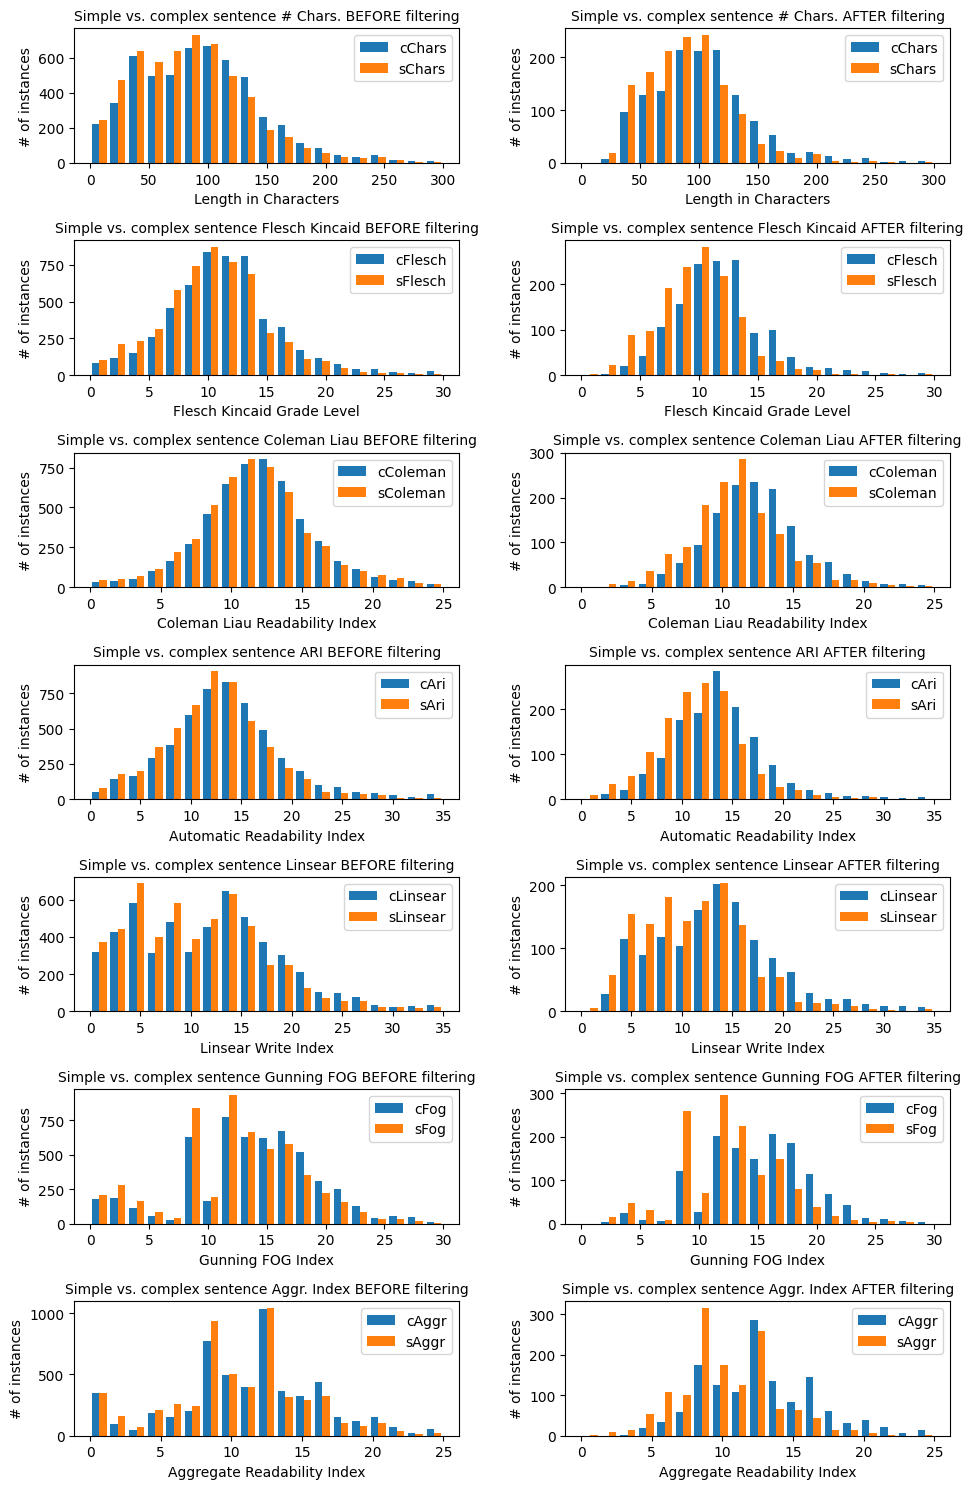

In [ ]:
from matplotlib import pyplot as plt
plt.style.use('default')
fig = plt.figure(figsize=(10,15))
fig.dpi = 100
bins = np.linspace(0, 300, 20) #single-sentence
#bins = np.linspace(0, 800, 20) #multi-sentence
ax1 = fig.add_subplot(721)
ax1.hist([df['cChars'], df['sChars']], bins, label=['cChars', 'sChars'])
ax1.set_title('Simple vs. complex sentence # Chars. BEFORE filtering', fontdict = {'fontsize':10})
ax1.legend(loc='upper right')
ax1.set_xlabel('Length in Characters')
ax1.set_ylabel('# of instances')

ax2 = fig.add_subplot(722)
ax2.hist([df4['cChars'], df4['sChars']], bins, label=['cChars', 'sChars'])
ax2.set_title('Simple vs. complex sentence # Chars. AFTER filtering', fontdict = {'fontsize':10})
ax2.legend(loc='upper right')
ax2.set_xlabel('Length in Characters')
ax2.set_ylabel('# of instances')

#Plot Flesch Kincaid Grade Level
bins = np.linspace(0, 30, 20) #single-sentence
#bins = np.linspace(0, 30, 20) #multi-sentence
ax1 = fig.add_subplot(723)
ax1.hist([df['cFlesch'], df['sFlesch']], bins, label=['cFlesch', 'sFlesch'])
ax1.set_title('Simple vs. complex sentence Flesch Kincaid BEFORE filtering', fontdict = {'fontsize':10})
ax1.legend(loc='upper right')
ax1.set_xlabel('Flesch Kincaid Grade Level')
ax1.set_ylabel('# of instances')

ax2 = fig.add_subplot(724)
ax2.hist([df4['cFlesch'], df4['sFlesch']], bins, label=['cFlesch', 'sFlesch'])
ax2.set_title('Simple vs. complex sentence Flesch Kincaid AFTER filtering', fontdict = {'fontsize':10})
ax2.legend(loc='upper right')
ax2.set_xlabel('Flesch Kincaid Grade Level')
ax2.set_ylabel('# of instances')


#Plot Coleman Liau
bins = np.linspace(0, 25, 20) #single-sentence
#bins = np.linspace(0, 25, 20) #multi-sentence
ax1 = fig.add_subplot(725)
ax1.hist([df['cColeman'], df['sColeman']], bins, label=['cColeman', 'sColeman'])
ax1.set_title('Simple vs. complex sentence Coleman Liau BEFORE filtering', fontdict = {'fontsize':10})
ax1.legend(loc='upper right')
ax1.set_xlabel('Coleman Liau Readability Index')
ax1.set_ylabel('# of instances')

ax2 = fig.add_subplot(726)
ax2.hist([df4['cColeman'], df4['sColeman']], bins, label=['cColeman', 'sColeman'])
ax2.set_title('Simple vs. complex sentence Coleman Liau AFTER filtering', fontdict = {'fontsize':10})
ax2.legend(loc='upper right')
ax2.set_xlabel('Coleman Liau Readability Index')
ax2.set_ylabel('# of instances')


#Plot Automatic Readability Index
bins = np.linspace(0, 35, 20) #single-sentence
#bins = np.linspace(0, 35, 20) #multi-sentence
ax1 = fig.add_subplot(727)
ax1.hist([df['cAri'], df['sAri']], bins, label=['cAri', 'sAri'])
ax1.set_title('Simple vs. complex sentence ARI BEFORE filtering', fontdict = {'fontsize':10})
ax1.legend(loc='upper right')
ax1.set_xlabel('Automatic Readability Index')
ax1.set_ylabel('# of instances')

ax2 = fig.add_subplot(728)
ax2.hist([df4['cAri'], df4['sAri']], bins, label=['cAri', 'sAri'])
ax2.set_title('Simple vs. complex sentence ARI AFTER filtering', fontdict = {'fontsize':10})
ax2.legend(loc='upper right')
ax2.set_xlabel('Automatic Readability Index')
ax2.set_ylabel('# of instances')


#Plot Linsear Write Formula
bins = np.linspace(0, 35, 20) #single-sentence
#bins = np.linspace(0, 35, 20) #multi-sentence
ax1 = fig.add_subplot(729)
ax1.hist([df['cLinsear'], df['sLinsear']], bins, label=['cLinsear', 'sLinsear'])
ax1.set_title('Simple vs. complex sentence Linsear BEFORE filtering', fontdict = {'fontsize':10})
ax1.legend(loc='upper right')
ax1.set_xlabel('Linsear Write Index')
ax1.set_ylabel('# of instances')

ax2 = fig.add_subplot(7,2,10)
ax2.hist([df4['cLinsear'], df4['sLinsear']], bins, label=['cLinsear', 'sLinsear'])
ax2.set_title('Simple vs. complex sentence Linsear AFTER filtering', fontdict = {'fontsize':10})
ax2.legend(loc='upper right')
ax2.set_xlabel('Linsear Write Index')
ax2.set_ylabel('# of instances')


#Plot Gunning FOG Formula
bins = np.linspace(0, 30, 20) #single-sentence
#bins = np.linspace(0, 30, 20) #multi-sentence
ax1 = fig.add_subplot(7,2,11)
ax1.hist([df['cFog'], df['sFog']], bins, label=['cFog', 'sFog'])
ax1.set_title('Simple vs. complex sentence Gunning FOG BEFORE filtering', fontdict = {'fontsize':10})
ax1.legend(loc='upper right')
ax1.set_xlabel('Gunning FOG Index')
ax1.set_ylabel('# of instances')

ax2 = fig.add_subplot(7,2,12)
ax2.hist([df4['cFog'], df4['sFog']], bins, label=['cFog', 'sFog'])
ax2.set_title('Simple vs. complex sentence Gunning FOG AFTER filtering', fontdict = {'fontsize':10})
ax2.legend(loc='upper right')
ax2.set_xlabel('Gunning FOG Index')
ax2.set_ylabel('# of instances')


#Plot Aggregate Readability Index
bins = np.linspace(0, 25, 20) #single-sentence
#bins = np.linspace(0, 25, 20) #multi-sentence
ax1 = fig.add_subplot(7,2,13)
ax1.hist([df['cAggr'], df['sAggr']], bins, label=['cAggr', 'sAggr'])
ax1.set_title('Simple vs. complex sentence Aggr. Index BEFORE filtering', fontdict = {'fontsize':10})
ax1.legend(loc='upper right')
ax1.set_xlabel('Aggregate Readability Index')
ax1.set_ylabel('# of instances')

ax2 = fig.add_subplot(7,2,14)
ax2.hist([df4['cAggr'], df4['sAggr']], bins, label=['cAggr', 'sAggr'])
ax2.set_title('Simple vs. complex sentence Aggr. Index AFTER filtering', fontdict = {'fontsize':10})
ax2.legend(loc='upper right')
ax2.set_xlabel('Aggregate Readability Index')
ax2.set_ylabel('# of instances')


fig.tight_layout()
#plt.savefig('df-df4_SingleSent_AllStats_ComplexSimple.pdf')
#plt.savefig('df-df4_MultiSent_AllStats_ComplexSimple.pdf')
plt.show()

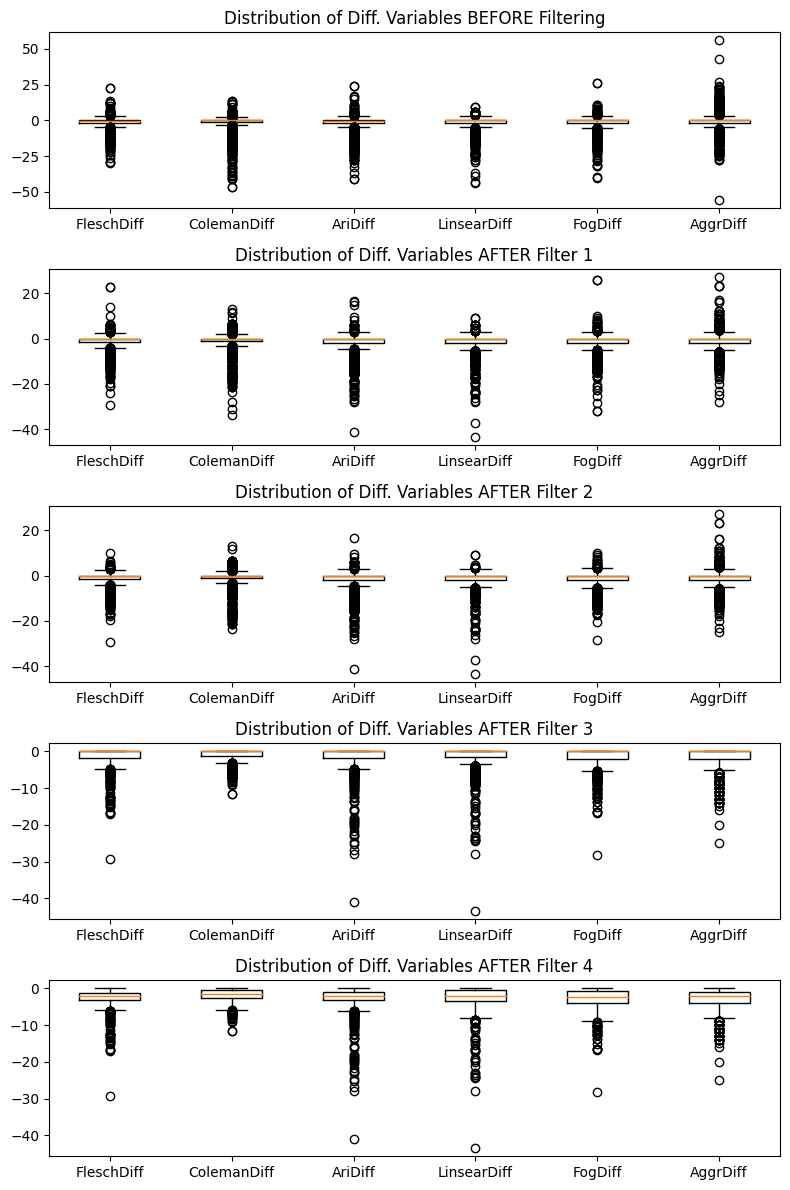

In [ ]:
plt.style.use('default')
fig = plt.figure(figsize=(8,12))
fig.dpi = 100

ax1 = fig.add_subplot(511)
ax1.boxplot([df['FleschDiff'],df['ColemanDiff'],df['AriDiff'],df['LinsearDiff'],df['FogDiff'],df['AggrDiff']], 
            labels=['FleschDiff', 'ColemanDiff', 'AriDiff', 'LinsearDiff', 'FogDiff', 'AggrDiff'])
ax1.set_title('Distribution of Diff. Variables BEFORE Filtering')

ax2 = fig.add_subplot(512)
ax2.boxplot([df1['FleschDiff'],df1['ColemanDiff'],df1['AriDiff'],df1['LinsearDiff'],df1['FogDiff'],df1['AggrDiff']], 
            labels=['FleschDiff', 'ColemanDiff', 'AriDiff', 'LinsearDiff', 'FogDiff', 'AggrDiff'])
ax2.set_title('Distribution of Diff. Variables AFTER Filter 1')

ax3 = fig.add_subplot(513)
ax3.boxplot([df2['FleschDiff'],df2['ColemanDiff'],df2['AriDiff'],df2['LinsearDiff'],df2['FogDiff'],df2['AggrDiff']], 
            labels=['FleschDiff', 'ColemanDiff', 'AriDiff', 'LinsearDiff', 'FogDiff', 'AggrDiff'])
ax3.set_title('Distribution of Diff. Variables AFTER Filter 2')

ax4 = fig.add_subplot(514)
ax4.boxplot([df3['FleschDiff'],df3['ColemanDiff'],df3['AriDiff'],df3['LinsearDiff'],df3['FogDiff'],df3['AggrDiff']], 
            labels=['FleschDiff', 'ColemanDiff', 'AriDiff', 'LinsearDiff', 'FogDiff', 'AggrDiff'])
ax4.set_title('Distribution of Diff. Variables AFTER Filter 3')

ax5 = fig.add_subplot(515)
ax5.boxplot([df4['FleschDiff'],df4['ColemanDiff'],df4['AriDiff'],df4['LinsearDiff'],df4['FogDiff'],df4['AggrDiff']], 
            labels=['FleschDiff', 'ColemanDiff', 'AriDiff', 'LinsearDiff', 'FogDiff', 'AggrDiff'])
ax5.set_title('Distribution of Diff. Variables AFTER Filter 4')

fig.tight_layout()

#plt.savefig('df-df4_SingleSent_DiffBox.pdf')
#plt.savefig('df-df4_MultiSent_DiffBox.pdf')
plt.show()

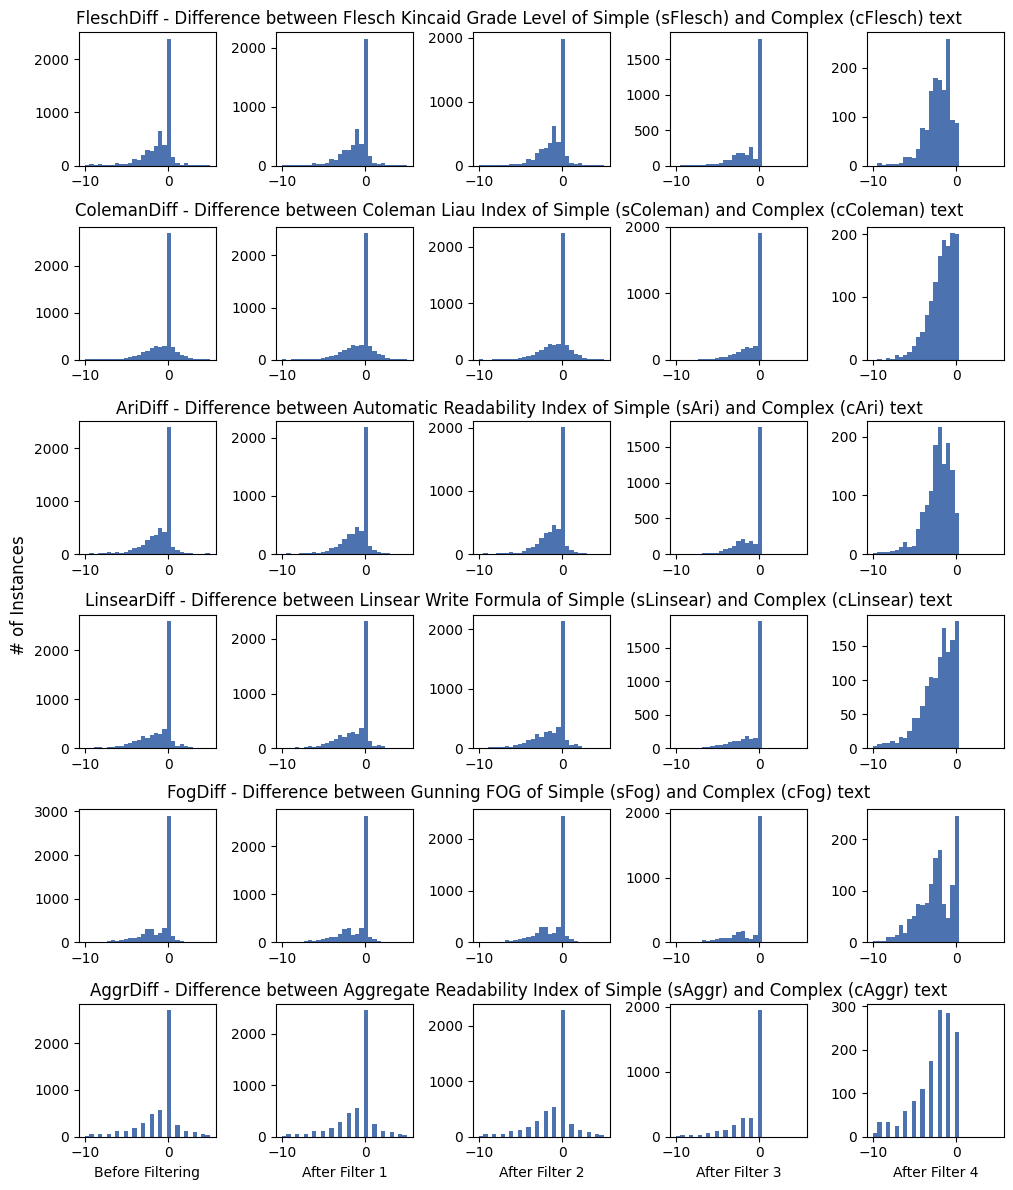

In [ ]:
from matplotlib import style
style.use('seaborn-deep')
fig = plt.figure(figsize=(10,12))
fig.dpi = 100

#Flesch Kincaid Differences
bins = np.linspace(-10, 5, 30)
ax1 = fig.add_subplot(651)
ax1.hist(df['FleschDiff'], bins)
#ax1.set_title('Before Filtering')

ax2 = fig.add_subplot(652)
ax2.hist(df1['FleschDiff'], bins)
#ax2.set_title('After Filter 1')

ax3 = fig.add_subplot(653)
ax3.hist(df2['FleschDiff'], bins)
#ax3.set_title('After Filter 2')

#bins = np.linspace(-7, 0, 30)
ax4 = fig.add_subplot(654)
ax4.hist(df3['FleschDiff'], bins)
#ax4.set_title('After Filter 3')

#bins = np.linspace(-10, 0, 30)
ax5 = fig.add_subplot(655)
ax5.hist(df4['FleschDiff'], bins)
#ax5.set_title('After Filter 4')
ax5.set_title(' ')

#Coleman Liau Differences
#bins = np.linspace(-5, 2, 30)
ax6 = fig.add_subplot(656)
#ax6.hist(df[df['ColemanDiff'] !=0]['ColemanDiff'], bins)
ax6.hist(df['ColemanDiff'], bins)
#ax6.set_title('Before Filtering')

ax7 = fig.add_subplot(657)
#ax7.hist(df1[df1['ColemanDiff'] !=0]['ColemanDiff'], bins)
ax7.hist(df1['ColemanDiff'], bins)
#ax7.set_title('After Filter 1')

ax8 = fig.add_subplot(658)
#ax8.hist(df2[df2['ColemanDiff'] !=0]['ColemanDiff'], bins)
ax8.hist(df2['ColemanDiff'], bins)
#ax8.set_title('After Filter 2')

#bins = np.linspace(-7, 0, 30)
ax9 = fig.add_subplot(659)
#ax9.hist(df3[df3['ColemanDiff'] !=0]['ColemanDiff'], bins)
ax9.hist(df3['ColemanDiff'], bins)
#ax9.set_title('After Filter 3')


#bins = np.linspace(-7, 0, 30)
ax10 = fig.add_subplot(6,5,10)
#ax10.hist(df4[df4['ColemanDiff'] !=0]['ColemanDiff'], bins)
ax10.hist(df4['ColemanDiff'], bins)
ax10.set_title(' ')

#ARI Differences
#bins = np.linspace(-7, 2, 30)

ax11 = fig.add_subplot(6,5,11)
ax11.hist(df['AriDiff'], bins)
ax12 = fig.add_subplot(6,5,12)
ax12.hist(df1['AriDiff'], bins)
ax13 = fig.add_subplot(6,5,13)
ax13.hist(df2['AriDiff'], bins)
ax14 = fig.add_subplot(6,5,14)
ax14.hist(df3['AriDiff'], bins)
ax15 = fig.add_subplot(6,5,15)
ax15.hist(df4['AriDiff'], bins)
ax15.set_title(' ')


#Linsear Differences
#bins = np.linspace(-7, 2, 30)

ax16 = fig.add_subplot(6,5,16)
ax16.hist(df['LinsearDiff'], bins)
ax17 = fig.add_subplot(6,5,17)
ax17.hist(df1['LinsearDiff'], bins)
ax18 = fig.add_subplot(6,5,18)
ax18.hist(df2['LinsearDiff'], bins)
ax19 = fig.add_subplot(6,5,19)
ax19.hist(df3['LinsearDiff'], bins)
ax20 = fig.add_subplot(6,5,20)
ax20.hist(df4['LinsearDiff'], bins)
ax20.set_title(' ')


#Gunning FOG Differences
#bins = np.linspace(-7, 2, 30)

ax21 = fig.add_subplot(6,5,21)
ax21.hist(df['FogDiff'], bins)
ax22 = fig.add_subplot(6,5,22)
ax22.hist(df1['FogDiff'], bins)
ax23 = fig.add_subplot(6,5,23)
ax23.hist(df2['FogDiff'], bins)
ax24 = fig.add_subplot(6,5,24)
ax24.hist(df3['FogDiff'], bins)
ax25 = fig.add_subplot(6,5,25)
ax25.hist(df4['FogDiff'], bins)
ax25.set_title(' ')


#Aggregate Index Differences
#bins = np.linspace(-12, 5, 30)

ax26 = fig.add_subplot(6,5,26)
ax26.hist(df['AggrDiff'], bins)
ax27 = fig.add_subplot(6,5,27)
ax27.hist(df1['AggrDiff'], bins)
ax28 = fig.add_subplot(6,5,28)
ax28.hist(df2['AggrDiff'], bins)
ax29 = fig.add_subplot(6,5,29)
ax29.hist(df3['AggrDiff'], bins)
ax30 = fig.add_subplot(6,5,30)
ax30.hist(df4['AggrDiff'], bins)
ax30.set_title(' ')

ax26.set_xlabel('Before Filtering')
ax27.set_xlabel('After Filter 1')
ax28.set_xlabel('After Filter 2')
ax29.set_xlabel('After Filter 3')
ax30.set_xlabel('After Filter 4')



fig.tight_layout()

fig.text(0.5,0.98, "FleschDiff - Difference between Flesch Kincaid Grade Level of Simple (sFlesch) and Complex (cFlesch) text", ha="center", va="center", fontsize = 12)
fig.text(0.5,0.82, "ColemanDiff - Difference between Coleman Liau Index of Simple (sColeman) and Complex (cColeman) text", ha="center", va="center", fontsize = 12)
fig.text(0.5,0.655, "AriDiff - Difference between Automatic Readability Index of Simple (sAri) and Complex (cAri) text", ha="center", va="center", fontsize = 12)
fig.text(0.5,0.495, "LinsearDiff - Difference between Linsear Write Formula of Simple (sLinsear) and Complex (cLinsear) text", ha="center", va="center", fontsize = 12)
fig.text(0.5,0.335, "FogDiff - Difference between Gunning FOG of Simple (sFog) and Complex (cFog) text", ha="center", va="center", fontsize = 12)
fig.text(0.5,0.17, "AggrDiff - Difference between Aggregate Readability Index of Simple (sAggr) and Complex (cAggr) text", ha="center", va="center", fontsize = 12)


fig.text(0,0.5, "# of Instances", ha="center", va="center", rotation=90, fontsize = 12)

#plt.savefig('df-df4_SingleSent_DiffHists.pdf')
#plt.savefig('df-df4_MultiSent_DiffHists.pdf')
plt.show()

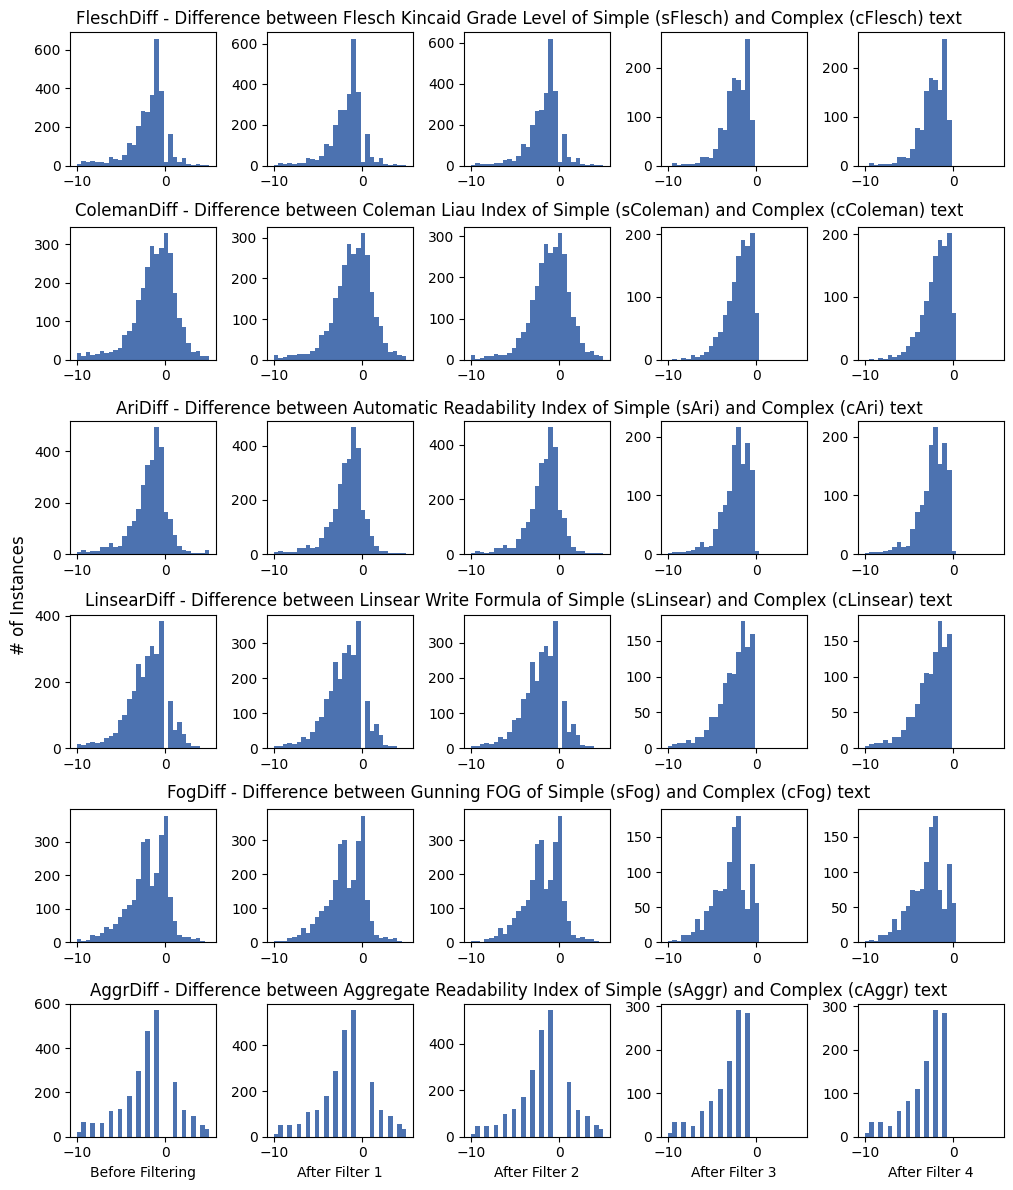

In [ ]:
# Creating Charts Ignoring instances with Difference values are 0
from matplotlib import style
style.use('seaborn-deep')
fig = plt.figure(figsize=(10,12))
fig.dpi = 100

#Flesch Kincaid Differences
bins = np.linspace(-10, 5, 30)
ax1 = fig.add_subplot(651)
ax1.hist(df[df['FleschDiff'] !=0]['FleschDiff'], bins)
#ax1.set_title('Before Filtering')

ax2 = fig.add_subplot(652)
ax2.hist(df1[df1['FleschDiff'] !=0]['FleschDiff'], bins)
#ax2.set_title('After Filter 1')

ax3 = fig.add_subplot(653)
ax3.hist(df2[df2['FleschDiff'] !=0]['FleschDiff'], bins)
#ax3.set_title('After Filter 2')

#bins = np.linspace(-7, 0, 30)
ax4 = fig.add_subplot(654)
ax4.hist(df3[df3['FleschDiff'] !=0]['FleschDiff'], bins)
#ax4.set_title('After Filter 3')

#bins = np.linspace(-10, 0, 30)
ax5 = fig.add_subplot(655)
ax5.hist(df4[df4['FleschDiff'] !=0]['FleschDiff'], bins)
#ax5.set_title('After Filter 4')
ax5.set_title(' ')

#Coleman Liau Differences
#bins = np.linspace(-5, 2, 30)
ax6 = fig.add_subplot(656)
ax6.hist(df[df['ColemanDiff'] !=0]['ColemanDiff'], bins)
#ax6.set_title('Before Filtering')

ax7 = fig.add_subplot(657)
ax7.hist(df1[df1['ColemanDiff'] !=0]['ColemanDiff'], bins)
#ax7.set_title('After Filter 1')

ax8 = fig.add_subplot(658)
ax8.hist(df2[df2['ColemanDiff'] !=0]['ColemanDiff'], bins)
#ax8.set_title('After Filter 2')

#bins = np.linspace(-7, 0, 30)
ax9 = fig.add_subplot(659)
ax9.hist(df3[df3['ColemanDiff'] !=0]['ColemanDiff'], bins)
#ax9.set_title('After Filter 3')

#bins = np.linspace(-7, 0, 30)
ax10 = fig.add_subplot(6,5,10)
ax10.hist(df4[df4['ColemanDiff'] !=0]['ColemanDiff'], bins)
ax10.set_title(' ')

#ARI Differences
#bins = np.linspace(-7, 2, 30)

ax11 = fig.add_subplot(6,5,11)
ax11.hist(df[df['AriDiff'] !=0]['AriDiff'], bins)
ax12 = fig.add_subplot(6,5,12)
ax12.hist(df1[df1['AriDiff'] !=0]['AriDiff'], bins)
ax13 = fig.add_subplot(6,5,13)
ax13.hist(df2[df2['AriDiff'] !=0]['AriDiff'], bins)
ax14 = fig.add_subplot(6,5,14)
ax14.hist(df3[df3['AriDiff'] !=0]['AriDiff'], bins)
ax15 = fig.add_subplot(6,5,15)
ax15.hist(df4[df4['AriDiff'] !=0]['AriDiff'], bins)
ax15.set_title(' ')


#Linsear Differences
#bins = np.linspace(-7, 2, 30)

ax16 = fig.add_subplot(6,5,16)
ax16.hist(df[df['LinsearDiff'] !=0]['LinsearDiff'], bins)
ax17 = fig.add_subplot(6,5,17)
ax17.hist(df1[df1['LinsearDiff'] !=0]['LinsearDiff'], bins)
ax18 = fig.add_subplot(6,5,18)
ax18.hist(df2[df2['LinsearDiff'] !=0]['LinsearDiff'], bins)
ax19 = fig.add_subplot(6,5,19)
ax19.hist(df3[df3['LinsearDiff'] !=0]['LinsearDiff'], bins)
ax20 = fig.add_subplot(6,5,20)
ax20.hist(df4[df4['LinsearDiff'] !=0]['LinsearDiff'], bins)
ax20.set_title(' ')


#Gunning FOG Differences
#bins = np.linspace(-7, 2, 30)

ax21 = fig.add_subplot(6,5,21)
ax21.hist(df[df['FogDiff'] !=0]['FogDiff'], bins)
ax22 = fig.add_subplot(6,5,22)
ax22.hist(df1[df1['FogDiff'] !=0]['FogDiff'], bins)
ax23 = fig.add_subplot(6,5,23)
ax23.hist(df2[df2['FogDiff'] !=0]['FogDiff'], bins)
ax24 = fig.add_subplot(6,5,24)
ax24.hist(df3[df3['FogDiff'] !=0]['FogDiff'], bins)
ax25 = fig.add_subplot(6,5,25)
ax25.hist(df4[df4['FogDiff'] !=0]['FogDiff'], bins)
ax25.set_title(' ')


#Aggregate Index Differences
#bins = np.linspace(-12, 5, 30)

ax26 = fig.add_subplot(6,5,26)
ax26.hist(df[df['AggrDiff'] !=0]['AggrDiff'], bins)
ax27 = fig.add_subplot(6,5,27)
ax27.hist(df1[df1['AggrDiff'] !=0]['AggrDiff'], bins)
ax28 = fig.add_subplot(6,5,28)
ax28.hist(df2[df2['AggrDiff'] !=0]['AggrDiff'], bins)
ax29 = fig.add_subplot(6,5,29)
ax29.hist(df3[df3['AggrDiff'] !=0]['AggrDiff'], bins)
ax30 = fig.add_subplot(6,5,30)
ax30.hist(df4[df4['AggrDiff'] !=0]['AggrDiff'], bins)
ax30.set_title(' ')

ax26.set_xlabel('Before Filtering')
ax27.set_xlabel('After Filter 1')
ax28.set_xlabel('After Filter 2')
ax29.set_xlabel('After Filter 3')
ax30.set_xlabel('After Filter 4')



fig.tight_layout()

fig.text(0.5,0.98, "FleschDiff - Difference between Flesch Kincaid Grade Level of Simple (sFlesch) and Complex (cFlesch) text", ha="center", va="center", fontsize = 12)
fig.text(0.5,0.82, "ColemanDiff - Difference between Coleman Liau Index of Simple (sColeman) and Complex (cColeman) text", ha="center", va="center", fontsize = 12)
fig.text(0.5,0.655, "AriDiff - Difference between Automatic Readability Index of Simple (sAri) and Complex (cAri) text", ha="center", va="center", fontsize = 12)
fig.text(0.5,0.495, "LinsearDiff - Difference between Linsear Write Formula of Simple (sLinsear) and Complex (cLinsear) text", ha="center", va="center", fontsize = 12)
fig.text(0.5,0.335, "FogDiff - Difference between Gunning FOG of Simple (sFog) and Complex (cFog) text", ha="center", va="center", fontsize = 12)
fig.text(0.5,0.17, "AggrDiff - Difference between Aggregate Readability Index of Simple (sAggr) and Complex (cAggr) text", ha="center", va="center", fontsize = 12)


fig.text(0,0.5, "# of Instances", ha="center", va="center", rotation=90, fontsize = 12)

#plt.savefig('df-df4_SingleSent_DiffHists_IgnoreZero.pdf')
#plt.savefig('df-df4_MultiSent_DiffHists_IgnoreZero.pdf')
plt.show()